<a href="https://colab.research.google.com/github/koerding/ApplyingToLabs/blob/main/projects/neurons/load_stringer_spontaneous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Universal data properties relevant to causal inference


In [1]:
Targets=['Hexaco','360PDA','Stringer','RNASeq']
Target=Targets[3]
print(Target)

RNASeq


In [2]:
# @title Load dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import os
import zipfile
import requests

In [3]:
def compute_covariance(data):
    """
    Compute the covariance matrix. If the data is sparse
    (mostly zeros), use a Poisson-adjusted correlation matrix instead.

    Parameters:
    - data (numpy.ndarray): Input data matrix where rows are samples and columns are features.

    Returns:
    - cov_matrix (numpy.ndarray): Covariance or Poisson-adjusted correlation matrix.
    """
    def is_sparse(matrix, threshold=0.5):
        """Check if the matrix is sparse (fraction of zeros exceeds threshold)."""
        zero_fraction = np.sum(matrix == 0) / matrix.size
        return zero_fraction > threshold

    def poisson_adjusted_correlation(data):
        """Compute Poisson-adjusted correlation matrix."""
        means = np.mean(data, axis=0)
        stds = np.sqrt(means)  # Poisson standard deviation
        normalized_data = (data - means) / stds
        normalized_cov = np.cov(normalized_data, rowvar=False)
        adjusted_corr = normalized_cov / np.outer(stds, stds)
        return adjusted_corr

    # Determine if the data is sparse
    sparse = is_sparse(data)

    if sparse:
        print("Data is sparse. Using Poisson-adjusted correlation matrix.")
        cov_matrix = poisson_adjusted_correlation(data)
    else:
        print("Data is dense. Using standard covariance calculation.")
        cov_matrix = np.cov(data, rowvar=False) / np.outer(
            np.std(data, axis=0, ddof=1), np.std(data, axis=0, ddof=1)
        )

    return cov_matrix


In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
def load_rnaseq_data():
    """
    Load RNASeq data, clean it, visualize it, and return the gene-by-cluster matrix.

    Returns:
    - data_matrix (numpy.ndarray): Cleaned gene-by-cluster expression matrix.
    """
    # Step 1: Download the file
    url = "https://www.dropbox.com/scl/fi/6pcw5lztnp9l0pcvjfiyt/medians.csv?rlkey=5997l65mvqczuqhbl87uqutfk&dl=1"
    local_file = "medians.csv"

    if not os.path.isfile(local_file):
        print("Downloading the file...")
        response = requests.get(url)
        with open(local_file, "wb") as f:
            f.write(response.content)
        print("Download complete.")

    # Step 2: Load the dataset
    medians_df = pd.read_csv(local_file)
    # Set the first column as the index (gene names)
    medians_df.set_index(medians_df.columns[0], inplace=True)
    # Remove trivial rows (all zero or mostly zero)
    medians_df = medians_df.loc[medians_df.sum(axis=1) > 0]
    # Remove trivial columns (all zero or mostly zero)
    medians_df = medians_df.loc[:, medians_df.sum(axis=0) > 0]

    # Step 3: Extract the gene-by-cluster matrix
    gene_names = medians_df.index  # Gene names (row identifiers)
    expression_matrix = medians_df.to_numpy()  # Expression values

    # Return the cleaned matrix
    data_matrix = expression_matrix
    return data_matrix



In [6]:
def load_hexaco_data():
    """
    Load the HEXACO personality dataset, clean it, visualize it, and return the numeric data matrix.

    Returns:
    - data_matrix (numpy.ndarray): Cleaned HEXACO data matrix containing numeric columns only.
    """
    # Step 1: Download the ZIP file
    hexaco_url = "https://www.dropbox.com/scl/fi/gpis8v7ojcwegqqco9ede/HEXACO.zip?rlkey=tnupayuu8bpwfgw8i50xtbub8&dl=1"
    hexaco_zip = "HEXACO.zip"

    if not os.path.isfile(hexaco_zip):
        print("Downloading HEXACO dataset...")
        response = requests.get(hexaco_url)
        with open(hexaco_zip, "wb") as f:
            f.write(response.content)
        print("Download complete.")

    # Step 2: Extract the ZIP file
    extracted_folder = "HEXACO_extracted"
    if not os.path.isdir(extracted_folder):
        with zipfile.ZipFile(hexaco_zip, "r") as zip_ref:
            zip_ref.extractall(extracted_folder)
        print(f"Extracted to {extracted_folder}.")

    # Step 3: Load the data
    hexaco_data_path = os.path.join(extracted_folder, "HEXACO", "data.csv")
    hexaco_df = pd.read_csv(hexaco_data_path, sep="\t")

    # Step 4: Clean the data (numeric columns only)
    hexaco_numeric_data = hexaco_df.select_dtypes(include=[np.number]).to_numpy()

    # Return the cleaned numeric data matrix
    data_matrix = hexaco_numeric_data
    return data_matrix


In [7]:
def load_pda360_data():
    """
    Load the 360PDA dataset, clean it, visualize it, and return the cleaned data matrix.

    Returns:
    - data_matrix (numpy.ndarray): Cleaned 360PDA data matrix with no missing rows.
    """
    # Step 1: Download the 360PDA dataset
    pda_url = "https://www.dropbox.com/scl/fi/53s5j5pbwkwxgjm3ywi9s/360PDA.tab?rlkey=3lrpa8zumxxbn5y5hkrfubi1i&dl=1"
    pda_file = "360PDA.tab"

    if not os.path.isfile(pda_file):
        print("Downloading 360PDA dataset...")
        response = requests.get(pda_url)
        with open(pda_file, "wb") as f:
            f.write(response.content)
        print("Download complete.")

    # Step 2: Load the dataset
    pda_df = pd.read_csv(pda_file, sep="\t")

    # Step 3: Clean the dataset
    # Exclude non-behavioral columns like "ID" if present
    if "ID" in pda_df.columns:
        pda_behavioral_data = pda_df.drop(columns=["ID"]).select_dtypes(include=[np.number]).to_numpy()
    else:
        pda_behavioral_data = pda_df.select_dtypes(include=[np.number]).to_numpy()

    # Remove rows with at least one missing value
    pda_cleaned_no_missing = pda_behavioral_data[~np.any(np.isnan(pda_behavioral_data), axis=1)]

    # Return the cleaned matrix
    data_matrix = pda_cleaned_no_missing
    return data_matrix


In [8]:
def load_stringer_data():
    """
    Load the Stringer spontaneous activity neuroscience dataset, visualize behavioral properties, and return the neural response matrix.

    Returns:
    - data_matrix (numpy.ndarray): Neural response matrix (`sresp`).
    """
    # Step 1: Data retrieval
    fname = "stringer_spontaneous.npy"
    url = "https://osf.io/dpqaj/download"

    if not os.path.isfile(fname):
        try:
            print("Downloading Stringer dataset...")
            r = requests.get(url)
        except requests.ConnectionError:
            raise Exception("Failed to download data!")
        else:
            if r.status_code != requests.codes.ok:
                raise Exception("Failed to download data!")
            else:
                with open(fname, "wb") as fid:
                    fid.write(r.content)
                print("Download complete.")

    # Step 2: Load the dataset
    dat = np.load(fname, allow_pickle=True).item()
    print("Dataset keys:", dat.keys())
    data_matrix = dat['sresp']  # Neural response matrix
    print("Neural response matrix shape:", data_matrix.shape)
    print("Number of features:", len(dat['stat']))

    # Step 3: Visualize behavioral data
    plt.figure(figsize=(15, 3))

    # Pupil area
    ax = plt.subplot(1, 5, 1)
    plt.plot(dat['pupilArea'][:500, 0])
    ax.set(xlabel='Timepoints', ylabel='Pupil Area')

    # Pupil center of mass (COM)
    ax = plt.subplot(1, 5, 2)
    plt.plot(dat['pupilCOM'][:500, :])
    ax.set(xlabel='Timepoints', ylabel='Pupil XY Position')

    # Face SVD component #0
    ax = plt.subplot(1, 5, 3)
    plt.plot(dat['beh_svd_time'][:500, 0])
    ax.set(xlabel='Timepoints', ylabel='Face SVD #0')

    # Face SVD component #1
    ax = plt.subplot(1, 5, 4)
    plt.plot(dat['beh_svd_time'][:500, 1])
    ax.set(xlabel='Timepoints', ylabel='Face SVD #1')

    # Scatter plot of Face SVD components
    ax = plt.subplot(1, 5, 5)
    plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
    ax.set(xlabel='Face SVD #0', ylabel='Face SVD #1')

    plt.tight_layout()
    plt.show()

    # Return the neural response matrix
    return data_matrix



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [9]:
def analyze_data_matrix(data_matrix):
    """
    Perform a series of analyses on the given data matrix, including visualization,
    PCA, covariance analysis, and residual analysis.

    Parameters:
    - data_matrix (numpy.ndarray): Input data matrix.

    Returns:
    - results (dict): Dictionary containing PCA components, explained variance,
      covariance matrices, and other intermediate results.
    """
    results = {}

    # Step 1: Heatmap of the raw data
    plt.figure(figsize=(10, 6))
    plt.imshow(np.log(data_matrix + 1), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title("Heatmap of Data Matrix")
    plt.show()

    # Step 2: PCA on the raw data
    pca = PCA()
    transformed_data = pca.fit_transform(data_matrix)  # Transformed data
    explained_variance = pca.explained_variance_ratio_  # Explained variance ratios
    results['explained_variance'] = explained_variance

    # Log-log plot of explained variance
    plt.figure(figsize=(8, 6))
    plt.loglog(
        np.arange(1, len(explained_variance) + 1),
        explained_variance,
        marker='o',
        linestyle='-',
        label='Explained Variance'
    )
    plt.xlabel('Principal Component Index (log scale)', fontsize=12)
    plt.ylabel('Explained Variance (log scale)', fontsize=12)
    plt.title('Log-Log Plot of Explained Variance', fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

    # Step 3: Covariance matrix of the original data
    # normalized_matrix = (data_matrix - data_matrix.mean(axis=1, keepdims=True)) / data_matrix.std(axis=1, keepdims=True)
    normalized_cov_matrix = compute_covariance(data_matrix)

    results['normalized_cov_matrix'] = normalized_cov_matrix

    # Visualize the covariance matrix
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_cov_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.show()

    # Histogram of covariance matrix elements
    plt.figure(figsize=(8, 6))
    plt.hist(
        normalized_cov_matrix.flatten(),
        bins=np.linspace(-1, 1, 101),
        alpha=0.7,
        color='blue',
        edgecolor='black'
    )
    plt.xlabel('Covariance Matrix Elements', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Covariance Matrix Elements (Range -1 to 1)', fontsize=14)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    # Step 4: Residual analysis with top 10 PCs
    top_10_pcs = pca.components_[:10]
    residual_data = data_matrix - data_matrix @ top_10_pcs.T @ top_10_pcs  # Remove top 10 PCs
    #normalized_matrix = (residual_data - residual_data.mean(axis=1, keepdims=True)) / residual_data.std(axis=1, keepdims=True)

    residual_cov_matrix = compute_covariance(residual_data)
    results['residual_cov_matrix'] = residual_cov_matrix

    # Histogram of residual covariance matrix elements
    plt.figure(figsize=(8, 6))
    plt.hist(
        residual_cov_matrix.flatten(),
        bins=np.linspace(-0.5, 0.5, 101),
        alpha=0.7,
        color='orange',
        edgecolor='black'
    )
    plt.xlabel('Residual Covariance Matrix Elements', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Residual Covariance Matrix Elements (Range -0.5 to 0.5)', fontsize=14)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    return results


## Below this starts the code that just analyses the relevant matrices

Loading and analyzing dataset: RNASeq
RNASeq data matrix shape: (10071, 387)


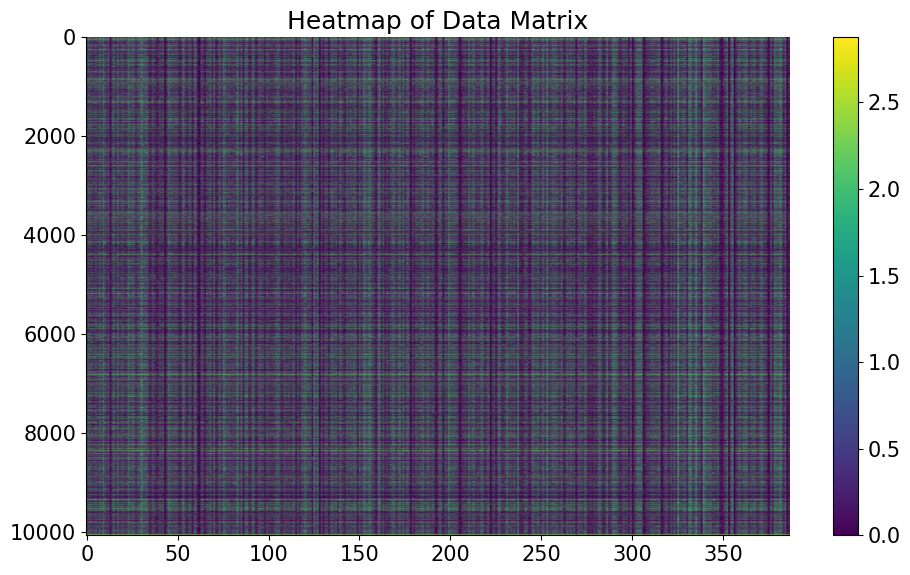

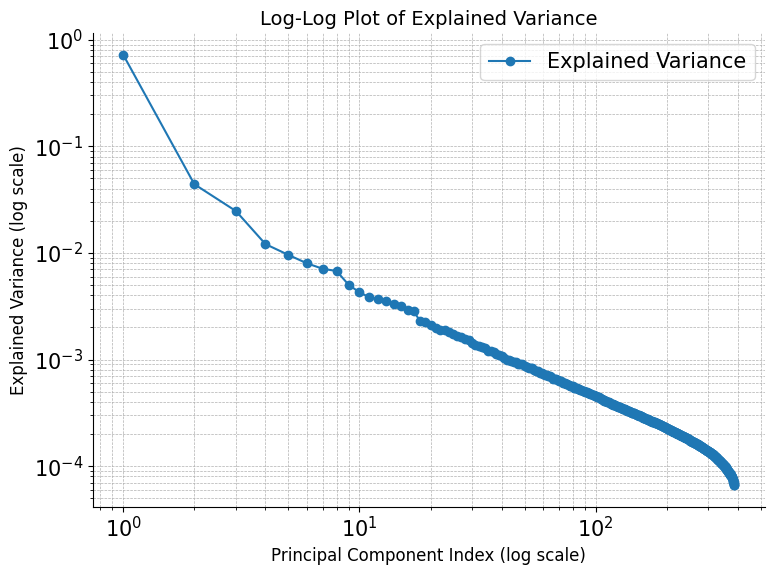

Data is sparse. Using Poisson-adjusted correlation matrix.


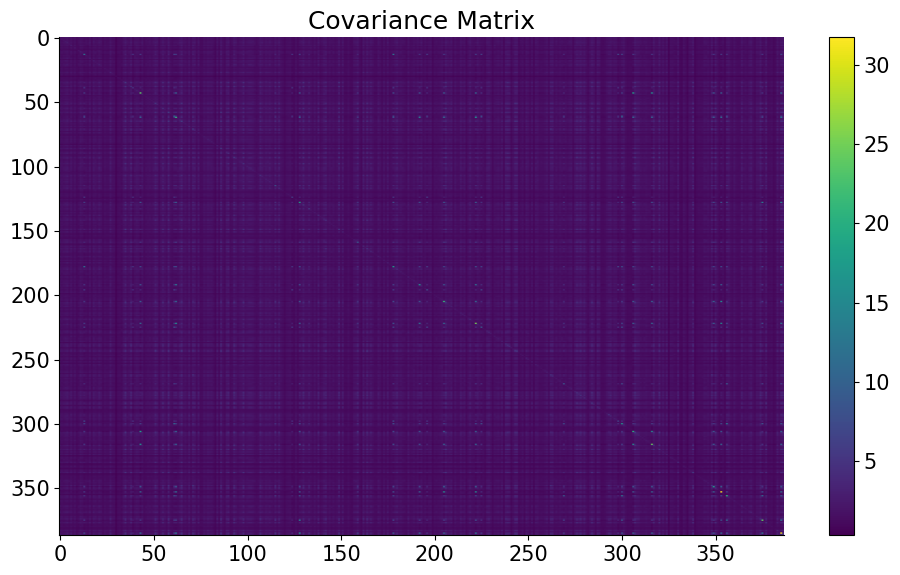

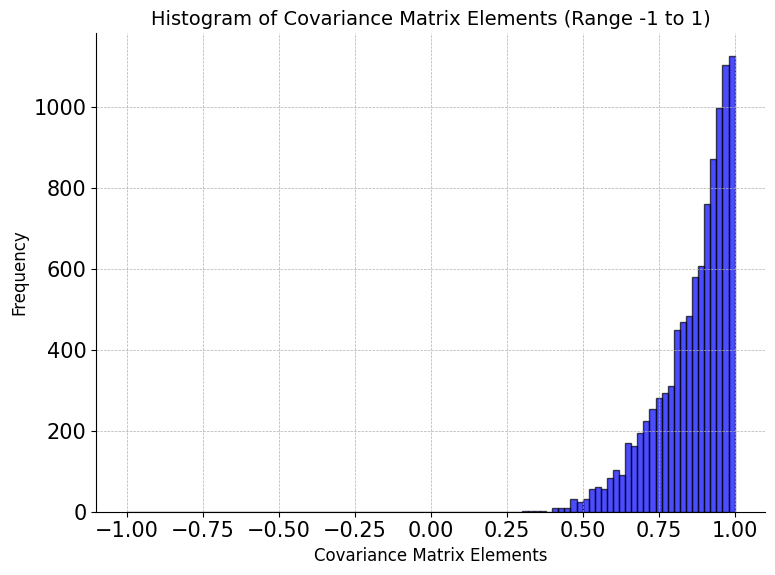

Data is dense. Using standard covariance calculation.


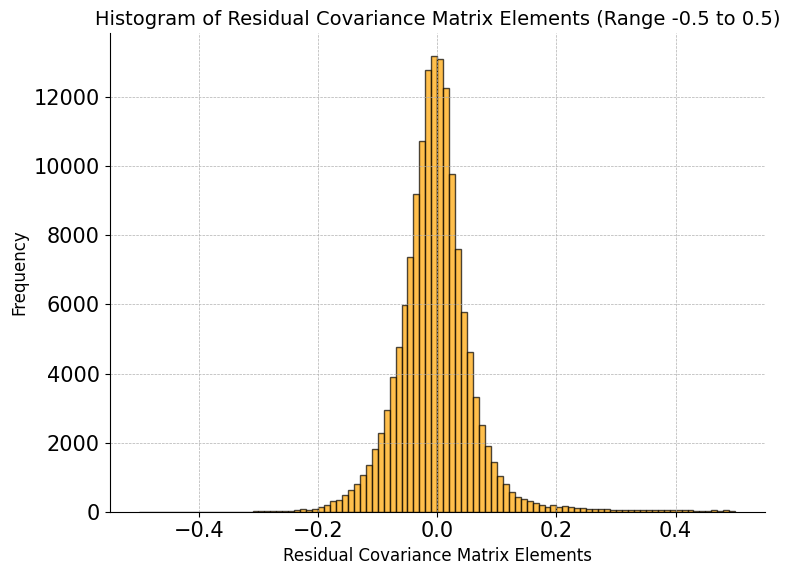

Analysis complete for RNASeq.

Loading and analyzing dataset: HEXACO


<ipython-input-6-4b50ea5caa3c>:28: DtypeWarning: Columns (243) have mixed types. Specify dtype option on import or set low_memory=False.
  hexaco_df = pd.read_csv(hexaco_data_path, sep="\t")


HEXACO data matrix shape: (22786, 242)


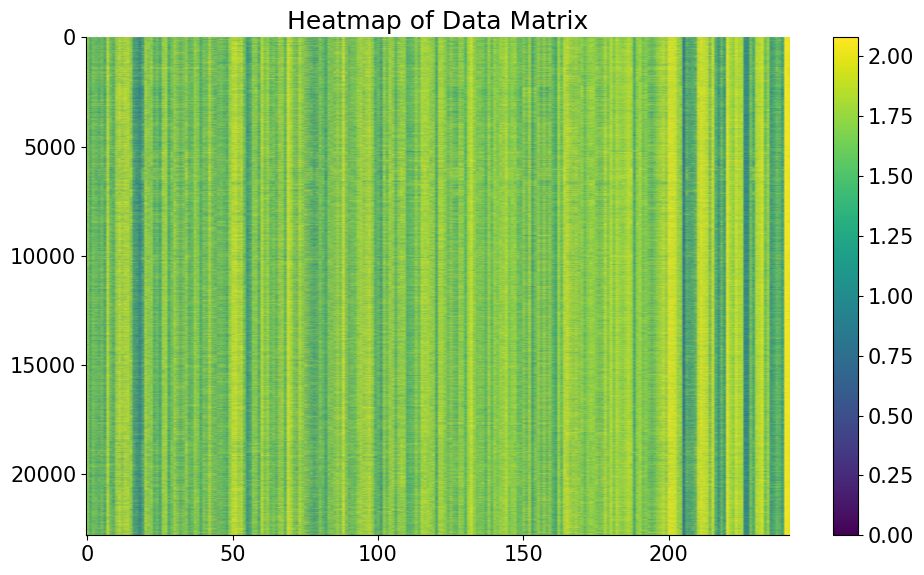

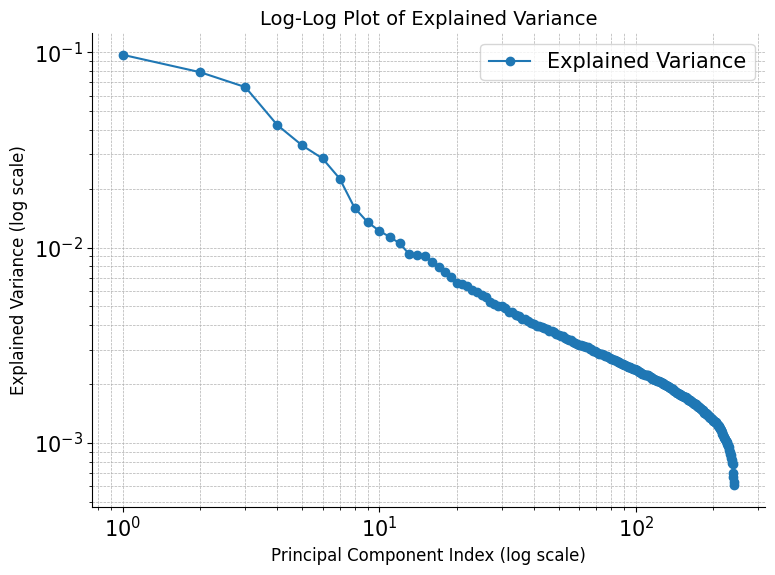

Data is dense. Using standard covariance calculation.


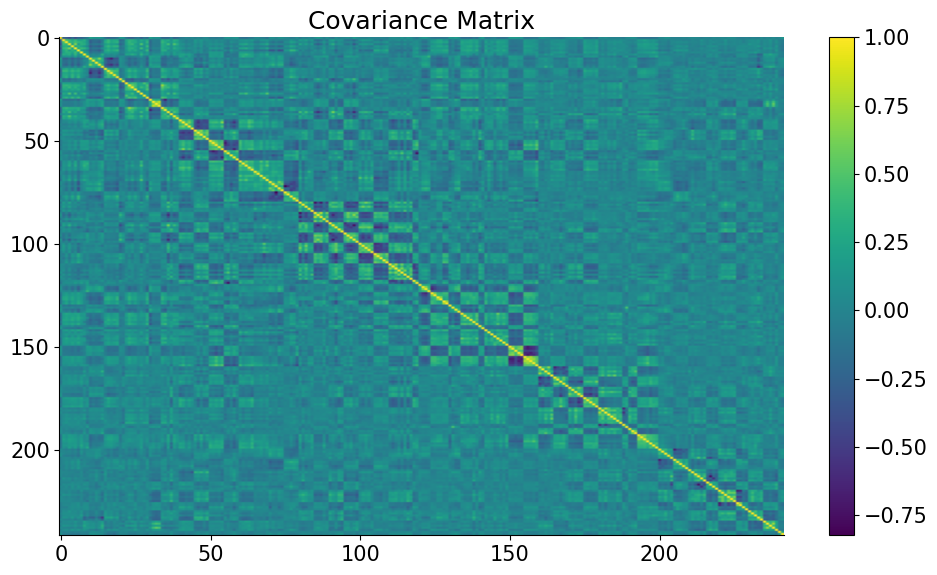

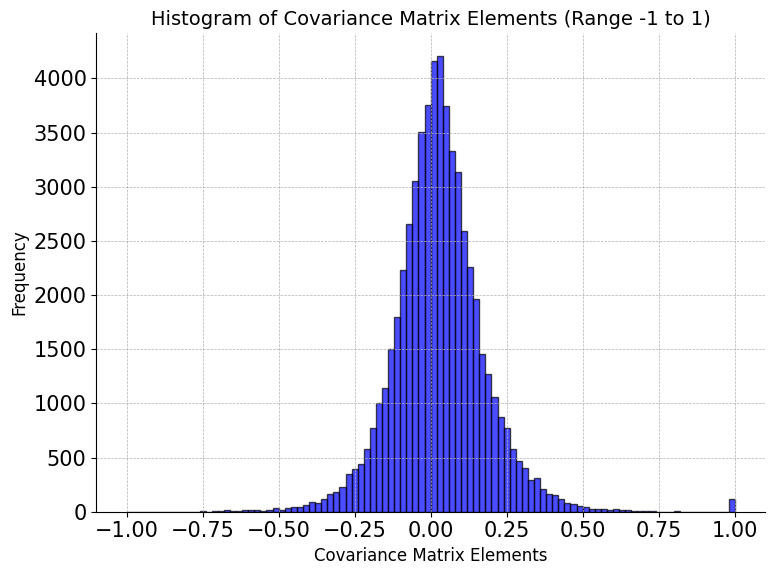

Data is dense. Using standard covariance calculation.


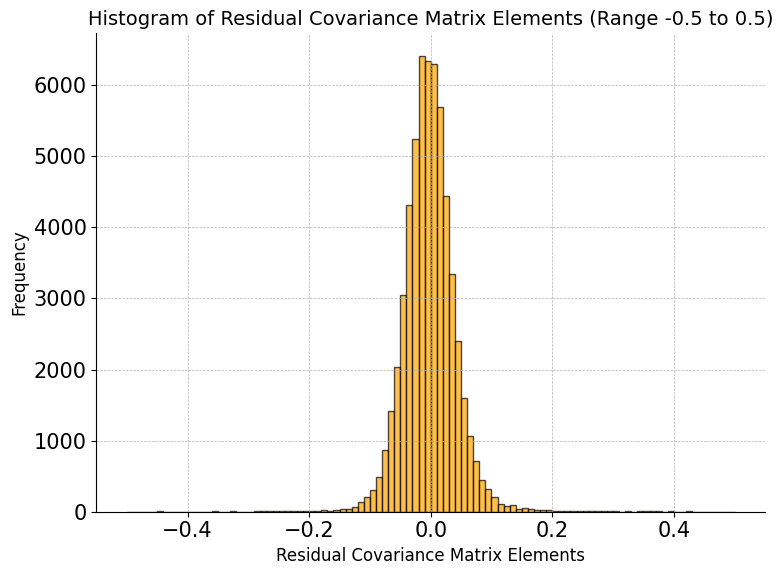

Analysis complete for HEXACO.

Loading and analyzing dataset: PDA360
PDA360 data matrix shape: (888, 360)


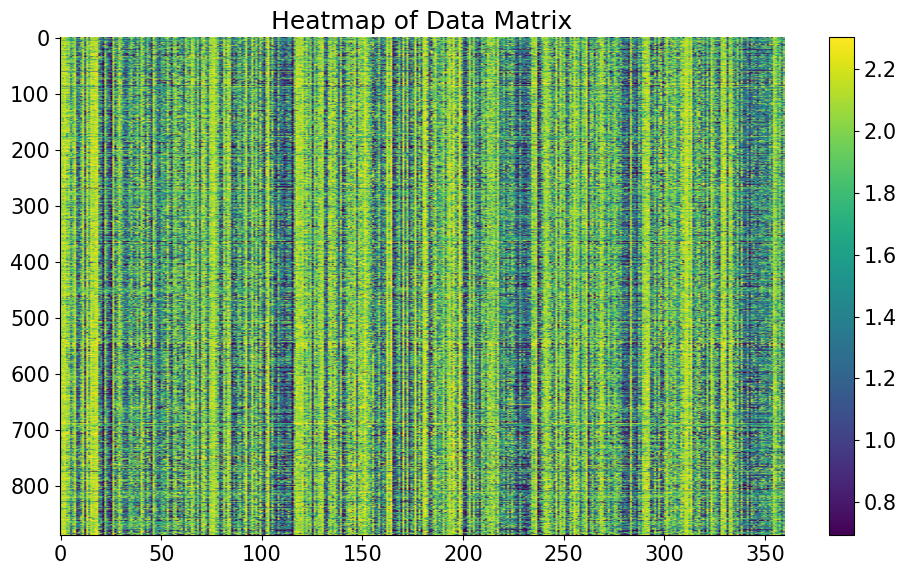

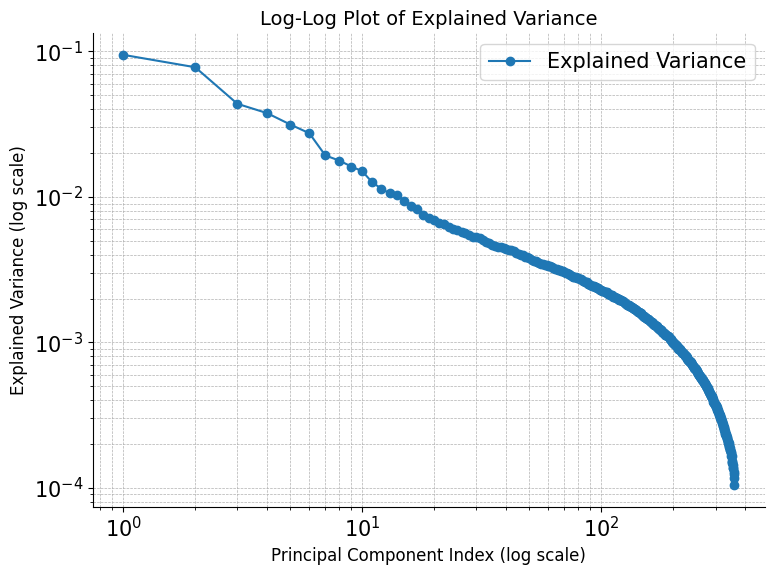

Data is dense. Using standard covariance calculation.


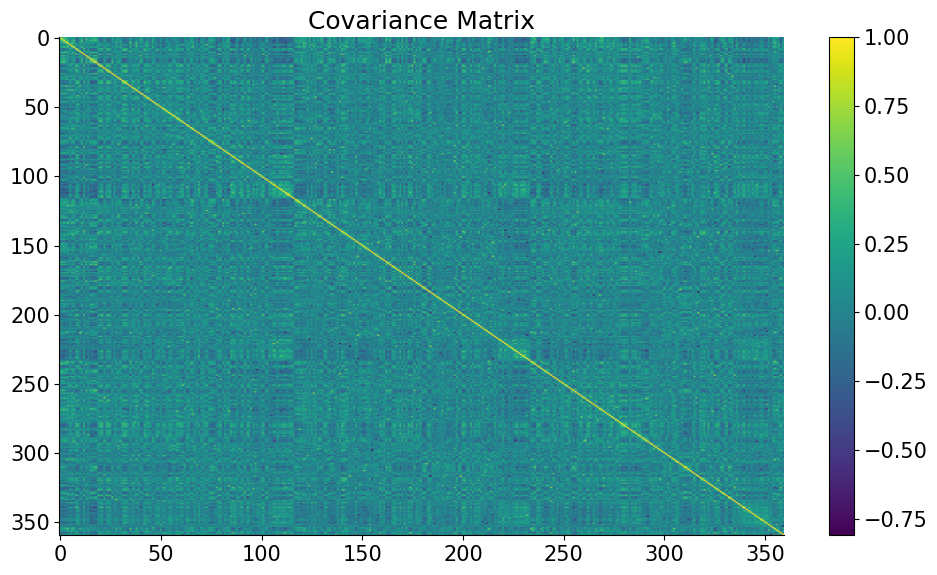

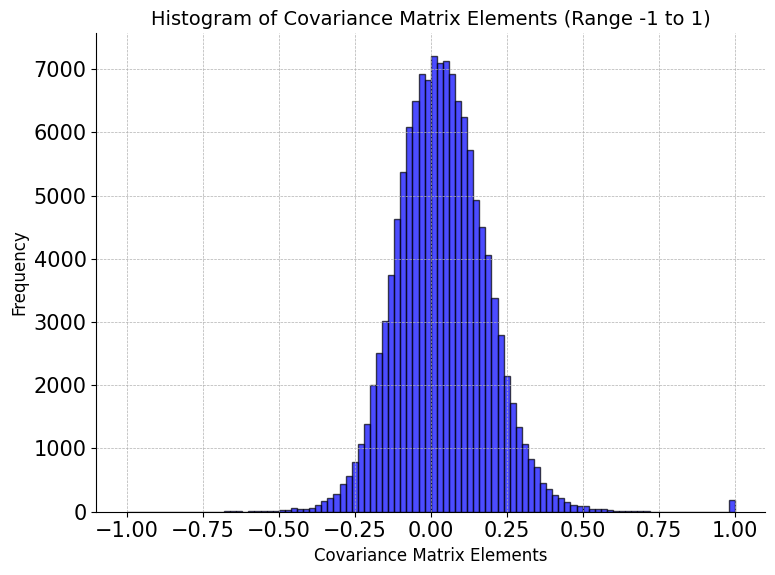

Data is dense. Using standard covariance calculation.


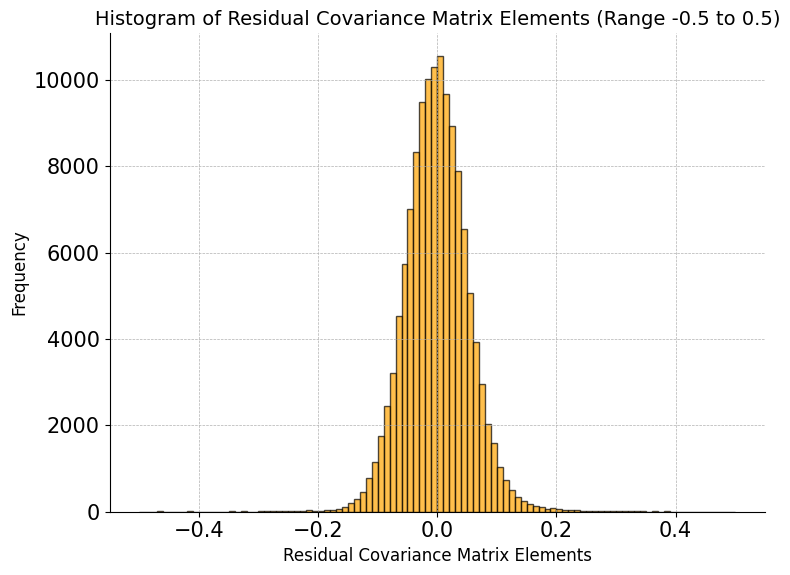

Analysis complete for PDA360.

Loading and analyzing dataset: Stringer
Dataset keys: dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])
Neural response matrix shape: (11983, 7018)
Number of features: 11983


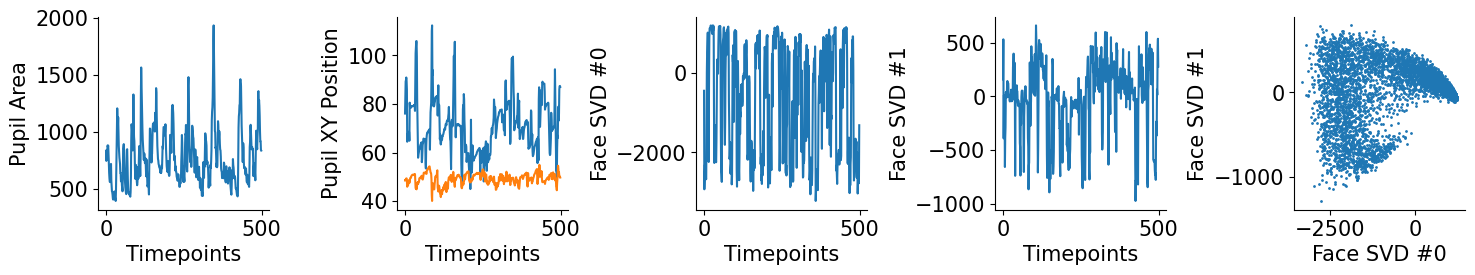

Stringer data matrix shape: (11983, 7018)


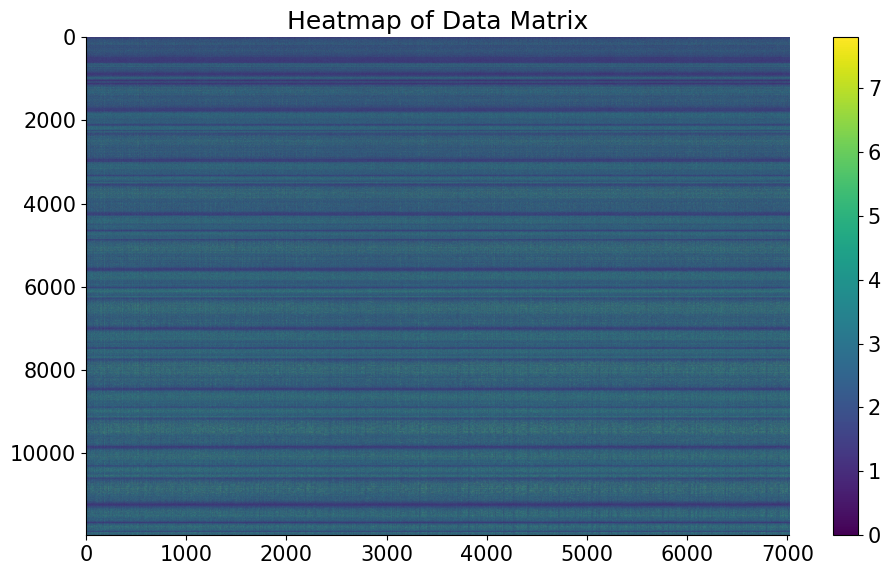

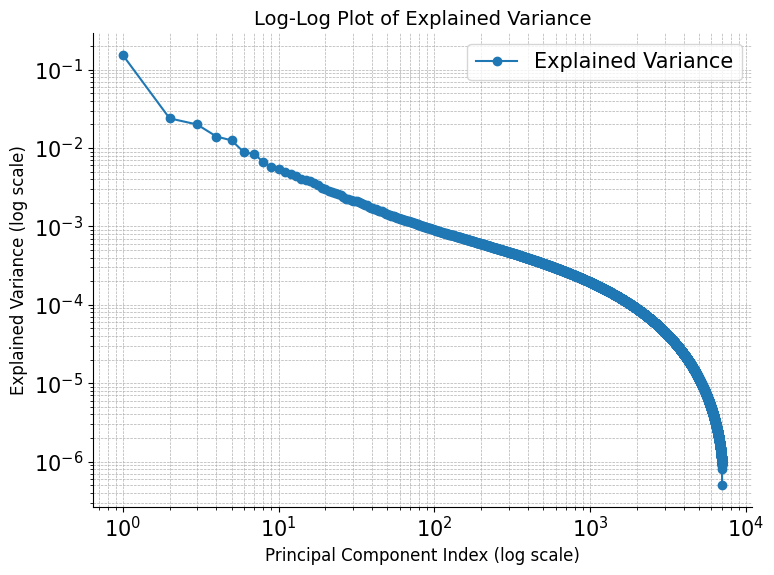

Data is dense. Using standard covariance calculation.


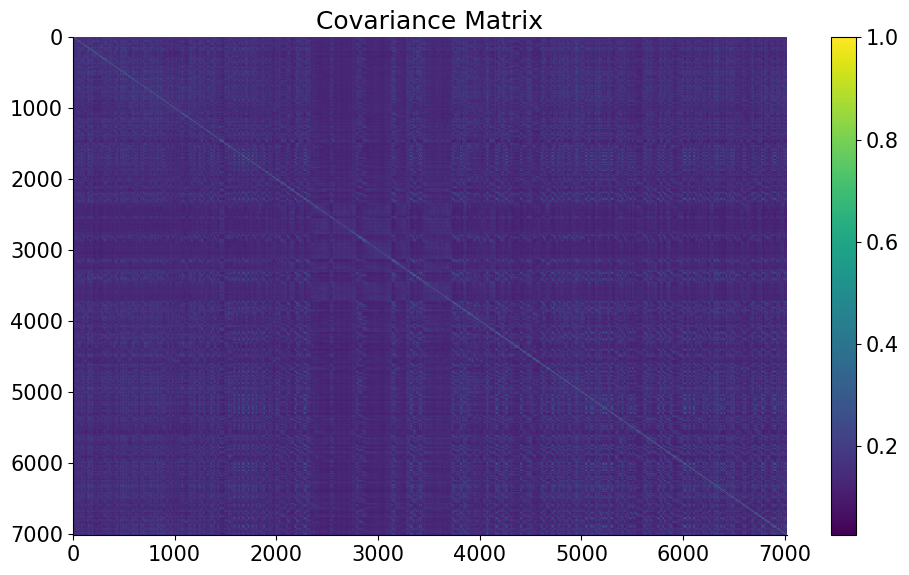

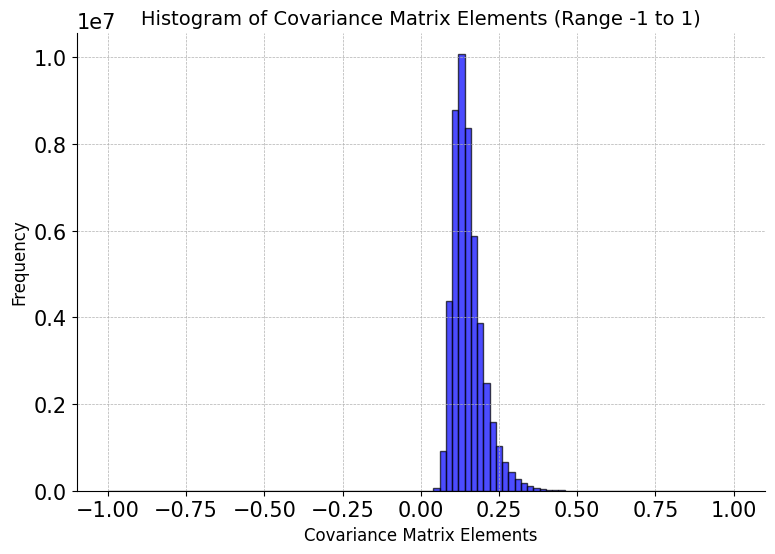

Data is dense. Using standard covariance calculation.


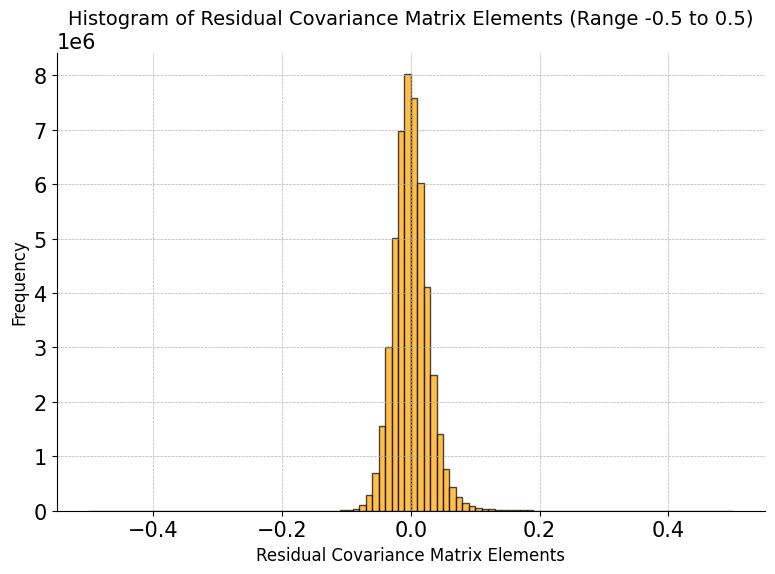

Analysis complete for Stringer.



In [10]:
# Define a dictionary to map dataset names to their respective loading functions
dataset_loaders = {
    "RNASeq": load_rnaseq_data,
    "HEXACO": load_hexaco_data,
    "PDA360": load_pda360_data,
    "Stringer": load_stringer_data
}

# Initialize a dictionary to store results for each dataset
all_results = {}

# Loop through each dataset
for dataset_name, loader_function in dataset_loaders.items():
    print(f"Loading and analyzing dataset: {dataset_name}")

    # Load the data matrix
    data_matrix = loader_function()
    print(f"{dataset_name} data matrix shape: {data_matrix.shape}")

    # Analyze the data matrix
    analysis_results = analyze_data_matrix(data_matrix)

    # Store the results
    all_results[dataset_name] = analysis_results
    print(f"Analysis complete for {dataset_name}.\n")

# all_results now contains the analysis outputs for all datasets
